# MRI Brain Tumor Classification

In [110]:
import numpy as np
import pandas as pd
import glob
import os
import cv2
import time
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tempfile import TemporaryDirectory
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.optim import lr_scheduler

## Variables

In [111]:
#Directory path
root_path = './data/BrainMRIClassification'

#Set device
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

#Recommended mean and std
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#Variables
batch_size = 16
learning_rate = 0.001

Using mps device


## Data Transform

In [112]:
#Set Transform
data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

## Data Loader

In [113]:
#Load images
image_ds = {x: datasets.ImageFolder(os.path.join(root_path, x), data_transforms) for x in ['train', 'test']}

#Set dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_ds[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}

#Check dataset sizes and classes
dataset_sizes = {x: len(image_ds[x]) for x in ['train', 'test']}
class_names = image_ds['train'].classes

print(f'train size: {dataset_sizes['train']}, test size: {dataset_sizes['test']}')
print(f'names of classes: {class_names}')

train size: 5712, test size: 1311
names of classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Visualizing Images

In [114]:
#Plot images
def plotimg(num = 4):
    imgs = {}
    for label in class_names:
        imgs[label] = []
        for img_path in glob.iglob(root_path + '/train/' + label + '/*'):
            img = cv2.imread(img_path) #get an image            
            img = cv2.resize(img, (128, 128)) #resize it
            b, g, r = cv2.split(img) #get the BGR values
            cv2.merge([r, g, b])
            imgs[label].append(img)
            
    for label in imgs:
        plt.figure(figsize = (16, 9))
        for i in range(num):
            plt.subplot(1, num, i + 1)
            plt.title(label)
            plt.imshow(imgs[label][random.randrange(len(imgs[label]))])


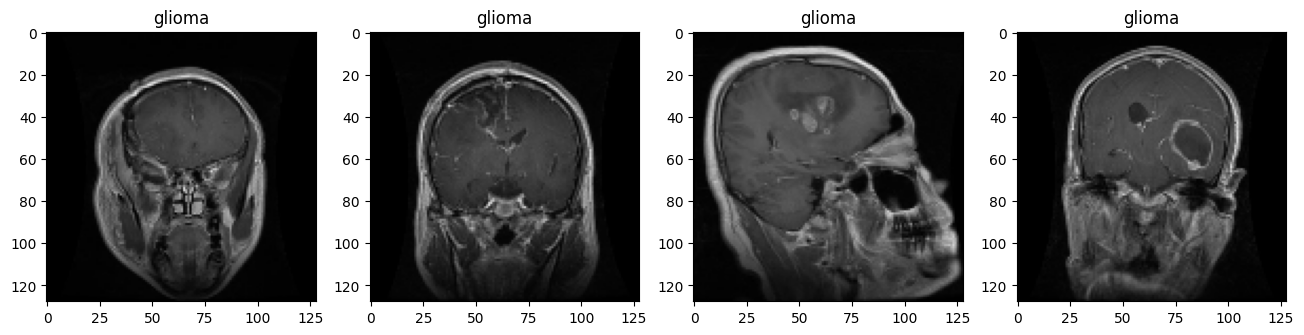

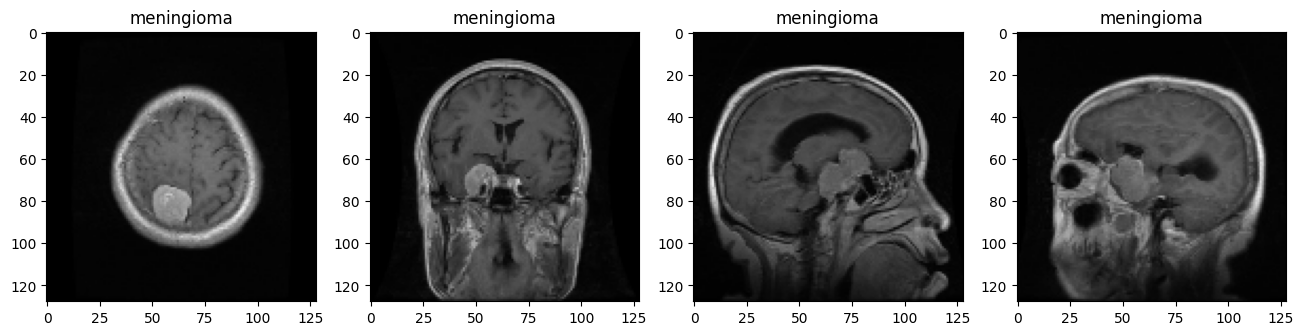

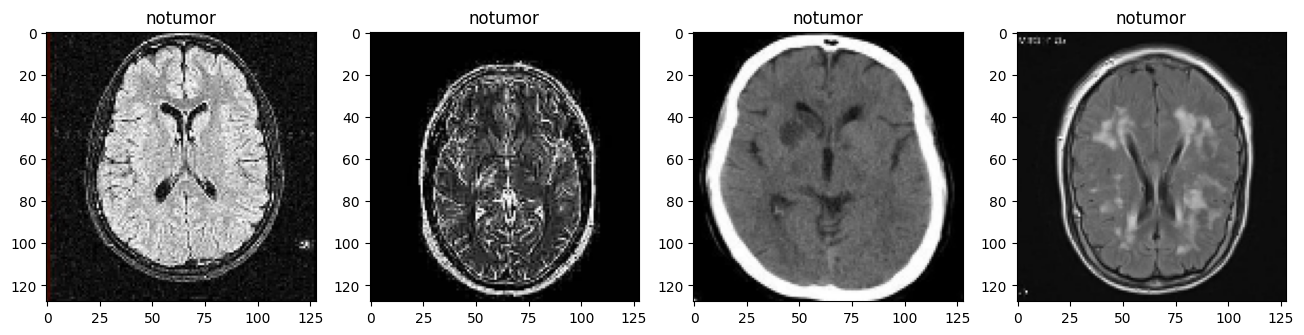

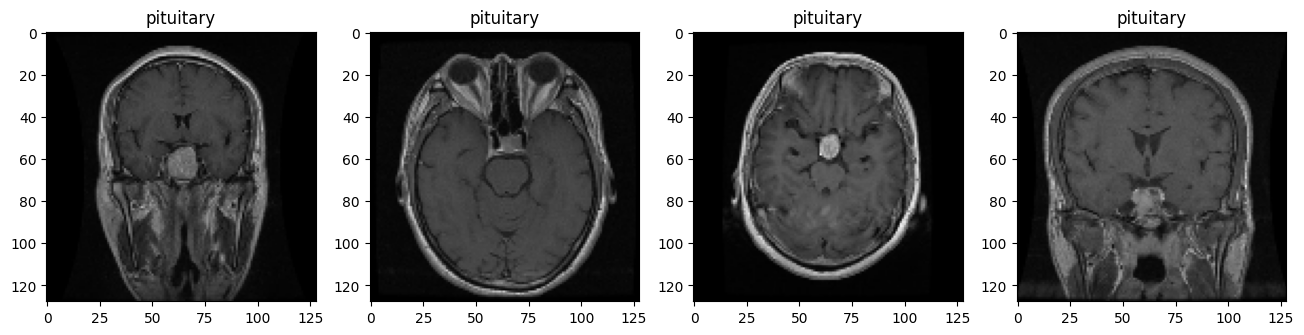

In [115]:
plotimg()

## Transfer Learning

In [116]:
transfer_models = ['resnet18', 'densenet121', 'efficientnet_v2_s']

In [117]:
def tranfer_learning(model_name):
    if model_name == 'resnet18':
        model = models.resnet18()
        num_ft = model.fc.in_features
        model.fc = nn.Linear(num_ft, 4)
        return model
        
    elif model_name == 'densenet121':
        model = models.efficientnet_v2_s()
        num_ft = model.classifier.in_features
        model.classifier = nn.Linear(num_ft, 4)
        return model
        
    elif model_name == 'efficientnet_v2_s':
        model = models.efficientnet_v2_s()
        num_ft = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ft, 4)
        return model
    else:
        print("I don't know that model")